# LinkedIn Post Analysis

This notebook analyzes LinkedIn posts to identify patterns in engagement, posting frequency, and content characteristics. The insights can help optimize posting strategy and content creation.

## Setup and Data Loading

In [2]:
!pip install seaborn
!pip install pandas matplotlib seaborn numpy

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp312-cp312-win_amd64.whl (218 kB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Lenovo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Lenovo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Set style
import seaborn as sns
sns.set_theme()
sns.set_palette('deep')

# Connect db and load data
def load_data(db_path='../linkedin_posts.db'):
    try:
        conn = sqlite3.connect(db_path)
        df = pd.read_sql_query('SELECT * FROM posts', conn)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        conn.close()
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = load_data()

print("Dataset Overview:")
print(f"Total posts: {len(df)}")
print(f"Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
print("\nMissing values:")
print(df.isnull().sum())

Dataset Overview:
Total posts: 1052
Date range: 2023-11-10 to 2024-11-09

Missing values:
post_id          0
profile_url      0
content          0
timestamp        0
likes            0
comments         0
has_image        0
has_video        0
media_type     616
dtype: int64


## 1. MOnthly and weekly Posting Frequency Analysis

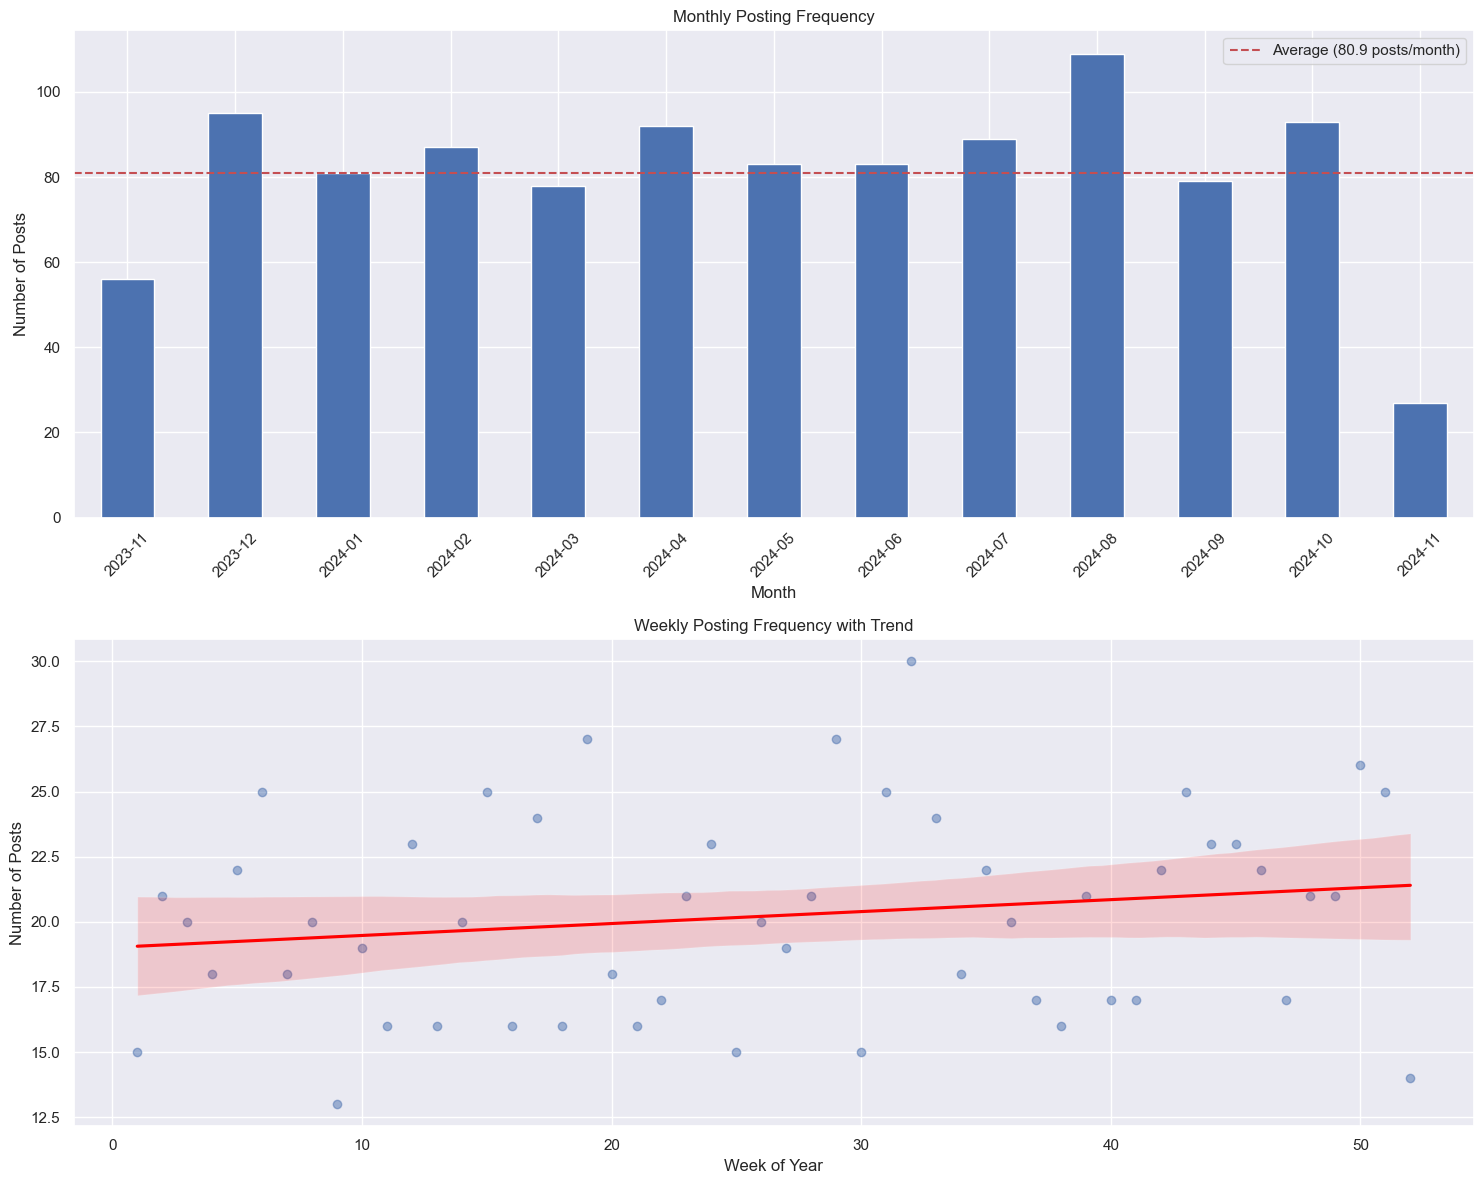

In [ ]:
def analyze_posting_frequency(df):
    monthly_posts = df.groupby(df['timestamp'].dt.to_period('M')).size()
    avg_monthly_posts = monthly_posts.mean()
    
    weekly_posts = df.groupby(df['timestamp'].dt.isocalendar().week).size()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Monthly posts plot
    monthly_posts.plot(kind='bar', ax=ax1)
    ax1.axhline(y=avg_monthly_posts, color='r', linestyle='--', 
                label=f'Average ({avg_monthly_posts:.1f} posts/month)')
    ax1.set_title('Monthly Posting Frequency')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Number of Posts')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()
    
    # Weekly posts plot
    sns.regplot(x=weekly_posts.index, y=weekly_posts.values, 
                scatter_kws={'alpha':0.5}, line_kws={'color': 'red'}, ax=ax2)
    ax2.set_title('Weekly Posting Frequency with Trend')
    ax2.set_xlabel('Week of Year')
    ax2.set_ylabel('Number of Posts')
    
    plt.tight_layout()
    plt.show()
    
    return monthly_posts, weekly_posts

monthly_posts, weekly_posts = analyze_posting_frequency(df)

## 2. Post and word len counts 

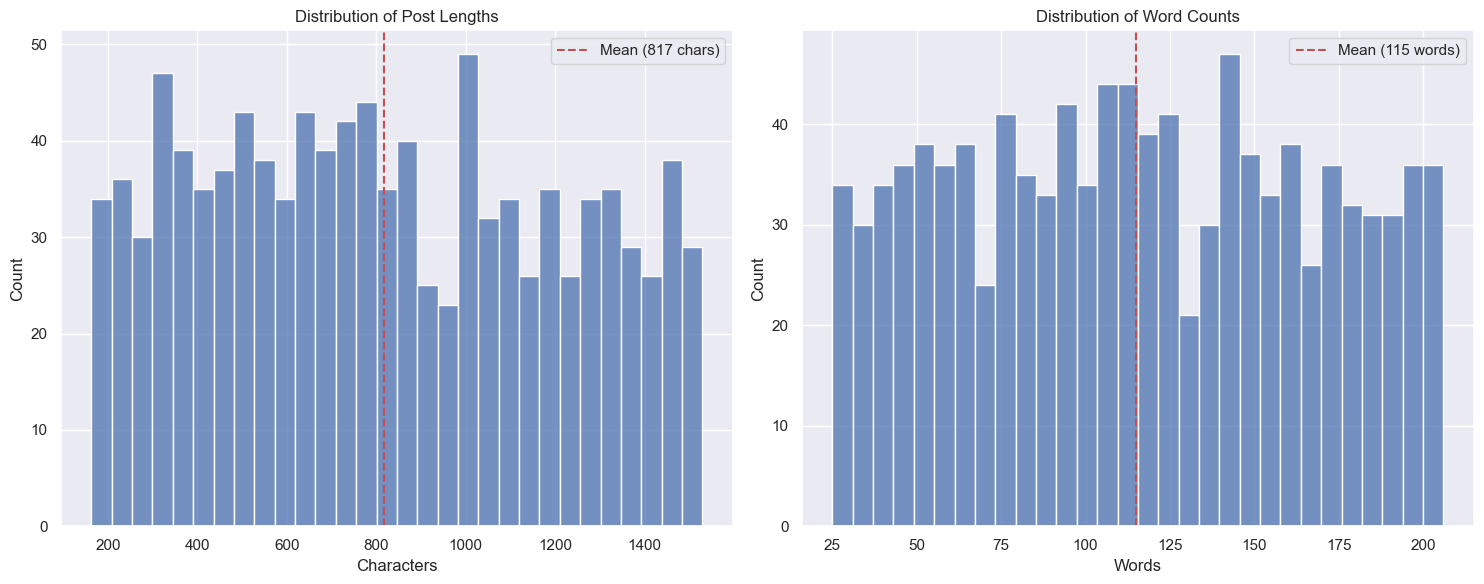

,Metric,Value
0,Average Length (chars),817
1,Average Words,115
2,Max Length,1529
3,Min Length,163


In [ ]:
def analyze_content(df):
    
    df['content_length'] = df['content'].str.len()
    df['word_count'] = df['content'].str.split().str.len()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Content length distribution
    sns.histplot(data=df, x='content_length', bins=30, ax=ax1)
    ax1.axvline(df['content_length'].mean(), color='r', linestyle='--', 
                label=f'Mean ({df["content_length"].mean():.0f} chars)')
    ax1.set_title('Distribution of Post Lengths')
    ax1.set_xlabel('Characters')
    ax1.legend()
    
    # Word count distribution
    sns.histplot(data=df, x='word_count', bins=30, ax=ax2)
    ax2.axvline(df['word_count'].mean(), color='r', linestyle='--',
                label=f'Mean ({df["word_count"].mean():.0f} words)')
    ax2.set_title('Distribution of Word Counts')
    ax2.set_xlabel('Words')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    content_stats = pd.DataFrame({
        'Metric': ['Average Length (chars)', 'Average Words', 'Max Length', 'Min Length'],
        'Value': [
            f"{df['content_length'].mean():.0f}",
            f"{df['word_count'].mean():.0f}",
            f"{df['content_length'].max():.0f}",
            f"{df['content_length'].min():.0f}"
        ]
    })
    display(content_stats)

analyze_content(df)

## 3. Media types and avg likes per media

None

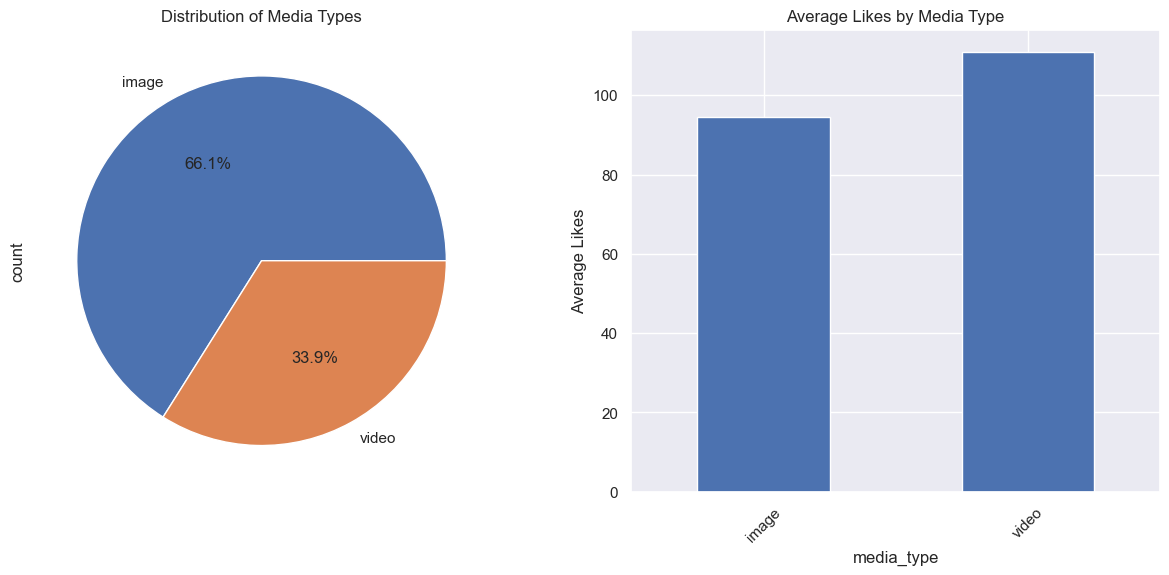

In [ ]:
def analyze_engagement(df):
    df['engagement'] = df['likes'] + df['comments']
    df['engagement_rate'] = df['engagement'] / df['likes'].mean()  
    
    media_metrics = df.groupby('media_type').agg({
        'likes': 'mean',
        'comments': 'mean',
        'engagement': 'mean',
        'media_type': 'count'
    }).rename(columns={'media_type': 'count'}).round(2)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Media type distribution
    media_counts = df['media_type'].value_counts()
    media_counts.plot(kind='pie', autopct='%1.1f%%', ax=ax1)
    ax1.set_title('Distribution of Media Types')
    
    # Average likes by media type
    media_metrics['likes'].plot(kind='bar', ax=ax2)
    ax2.set_title('Average Likes by Media Type')
    ax2.set_ylabel('Average Likes')
    ax2.tick_params(axis='x', rotation=45)
    


media_metrics = analyze_engagement(df)
display(media_metrics)